In [1]:
# Pyspark libraries
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

import numpy as np
import pandas as pd

# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='darkgrid', rc={'figure.figsize': (20,6)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Spark Session 
sc = SparkContext(appName = "Bitcoin Trend Analysis")
spark = SparkSession.Builder().getOrCreate()

# SQL Context
sqlContext = SQLContext(sc)

In [3]:
# Load csv file to spark dataframe
df= sqlContext.read.csv('D:/Projects/BitCoin-Trend Analysis/DataSets/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv', header='true', inferSchema='true')

In [4]:
df.describe().show()

+-------+-------------------+-------+-------+-------+-------+------------+-----------------+--------------+
|summary|          Timestamp|   Open|   High|    Low|  Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+-------+-------------------+-------+-------+-------+-------+------------+-----------------+--------------+
|  count|            4363457|4363457|4363457|4363457|4363457|     4363457|          4363457|       4363457|
|   mean|1.456468818686358E9|    NaN|    NaN|    NaN|    NaN|         NaN|              NaN|           NaN|
| stddev|7.573296191025247E7|    NaN|    NaN|    NaN|    NaN|         NaN|              NaN|           NaN|
|    min|         1325317920|    3.8|    3.8|    1.5|    1.5|         0.0|              0.0|           3.8|
|    max|         1587513600|    NaN|    NaN|    NaN|    NaN|         NaN|              NaN|           NaN|
+-------+-------------------+-------+-------+-------+-------+------------+-----------------+--------------+



In [5]:
df.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [6]:
df.registerTempTable("bitCoinData")

In [7]:
# Change 
bitCoinData = sqlContext.sql("select *,from_unixtime(Timestamp) as `dateTime` from bitCoinData")

In [8]:
# Remove all Null
bitCoinData = bitCoinData.na.drop()

In [9]:
bitCoinData.count()

3126480

In [10]:
bitCoinData.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)



In [11]:
bitCoinData = bitCoinData.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [12]:
dateTimeDF = bitCoinData

In [13]:
# Create two new columns for date and time by splitting Time dateTime column
splitDF = dateTimeDF.withColumn("date",split(col("dateTime")," ").getItem(0)).withColumn("time",split(col("dateTime")," ").getItem(1))

# Set onother column for Hour 
splitDF = splitDF.withColumn("hour",split(col("time"),":").getItem(0))

In [14]:
splitDF.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)



In [15]:
splitDF.show(10)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 13:22:00|2011-12-31|13:22:00|  13|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 21:20:00|2011-12-31|21:20:00|  21|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 22:29:00|2011-12-31|22:29:00|  22|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 22:30:00|2011-12-31|22:30:00|  22|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 09:46:00|2012-01-01|09:46:00|  09|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|   

In [16]:
#Add new Column for get the day of the week by the date
splitDF= splitDF.withColumn("date",splitDF["date"].cast(DateType())).withColumn("hour",splitDF["hour"].cast(DoubleType())).withColumn("dateTime",splitDF["dateTime"].cast(DateType()))
splitDF=splitDF.withColumn('day_of_week',dayofweek(splitDF.date))

#SPLit Year
splitDF = splitDF.withColumn("year",split(col("date"),"-").getItem(0))

In [17]:
splitDF.show(10)

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|13:22:00|13.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|21:20:00|21.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|22:29:00|22.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|22:30:00|22.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|09:46:00| 9.0|  

In [18]:
# Covert spark dataframe to pandas dataframe
pandasDF = splitDF.toPandas()

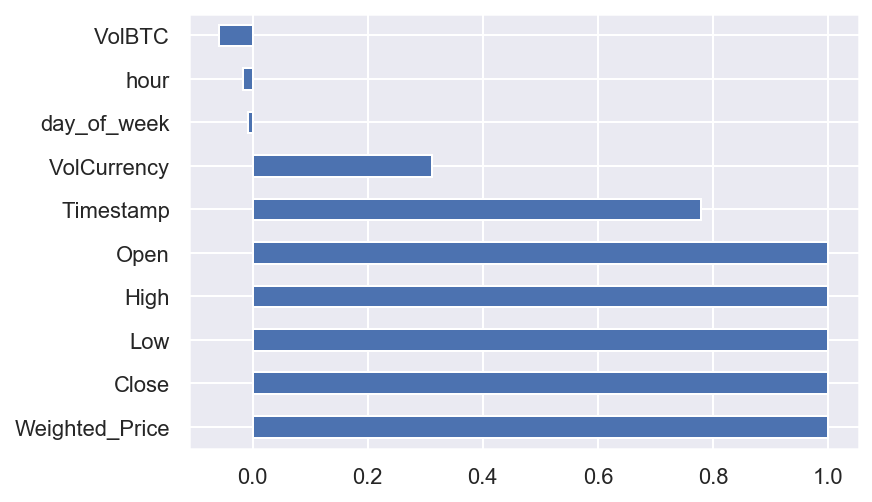

In [19]:
correlationMatrix=pandasDF.corr()
(correlationMatrix
      .Weighted_Price
      .sort_values(ascending=False)
      .plot
      .barh(5))

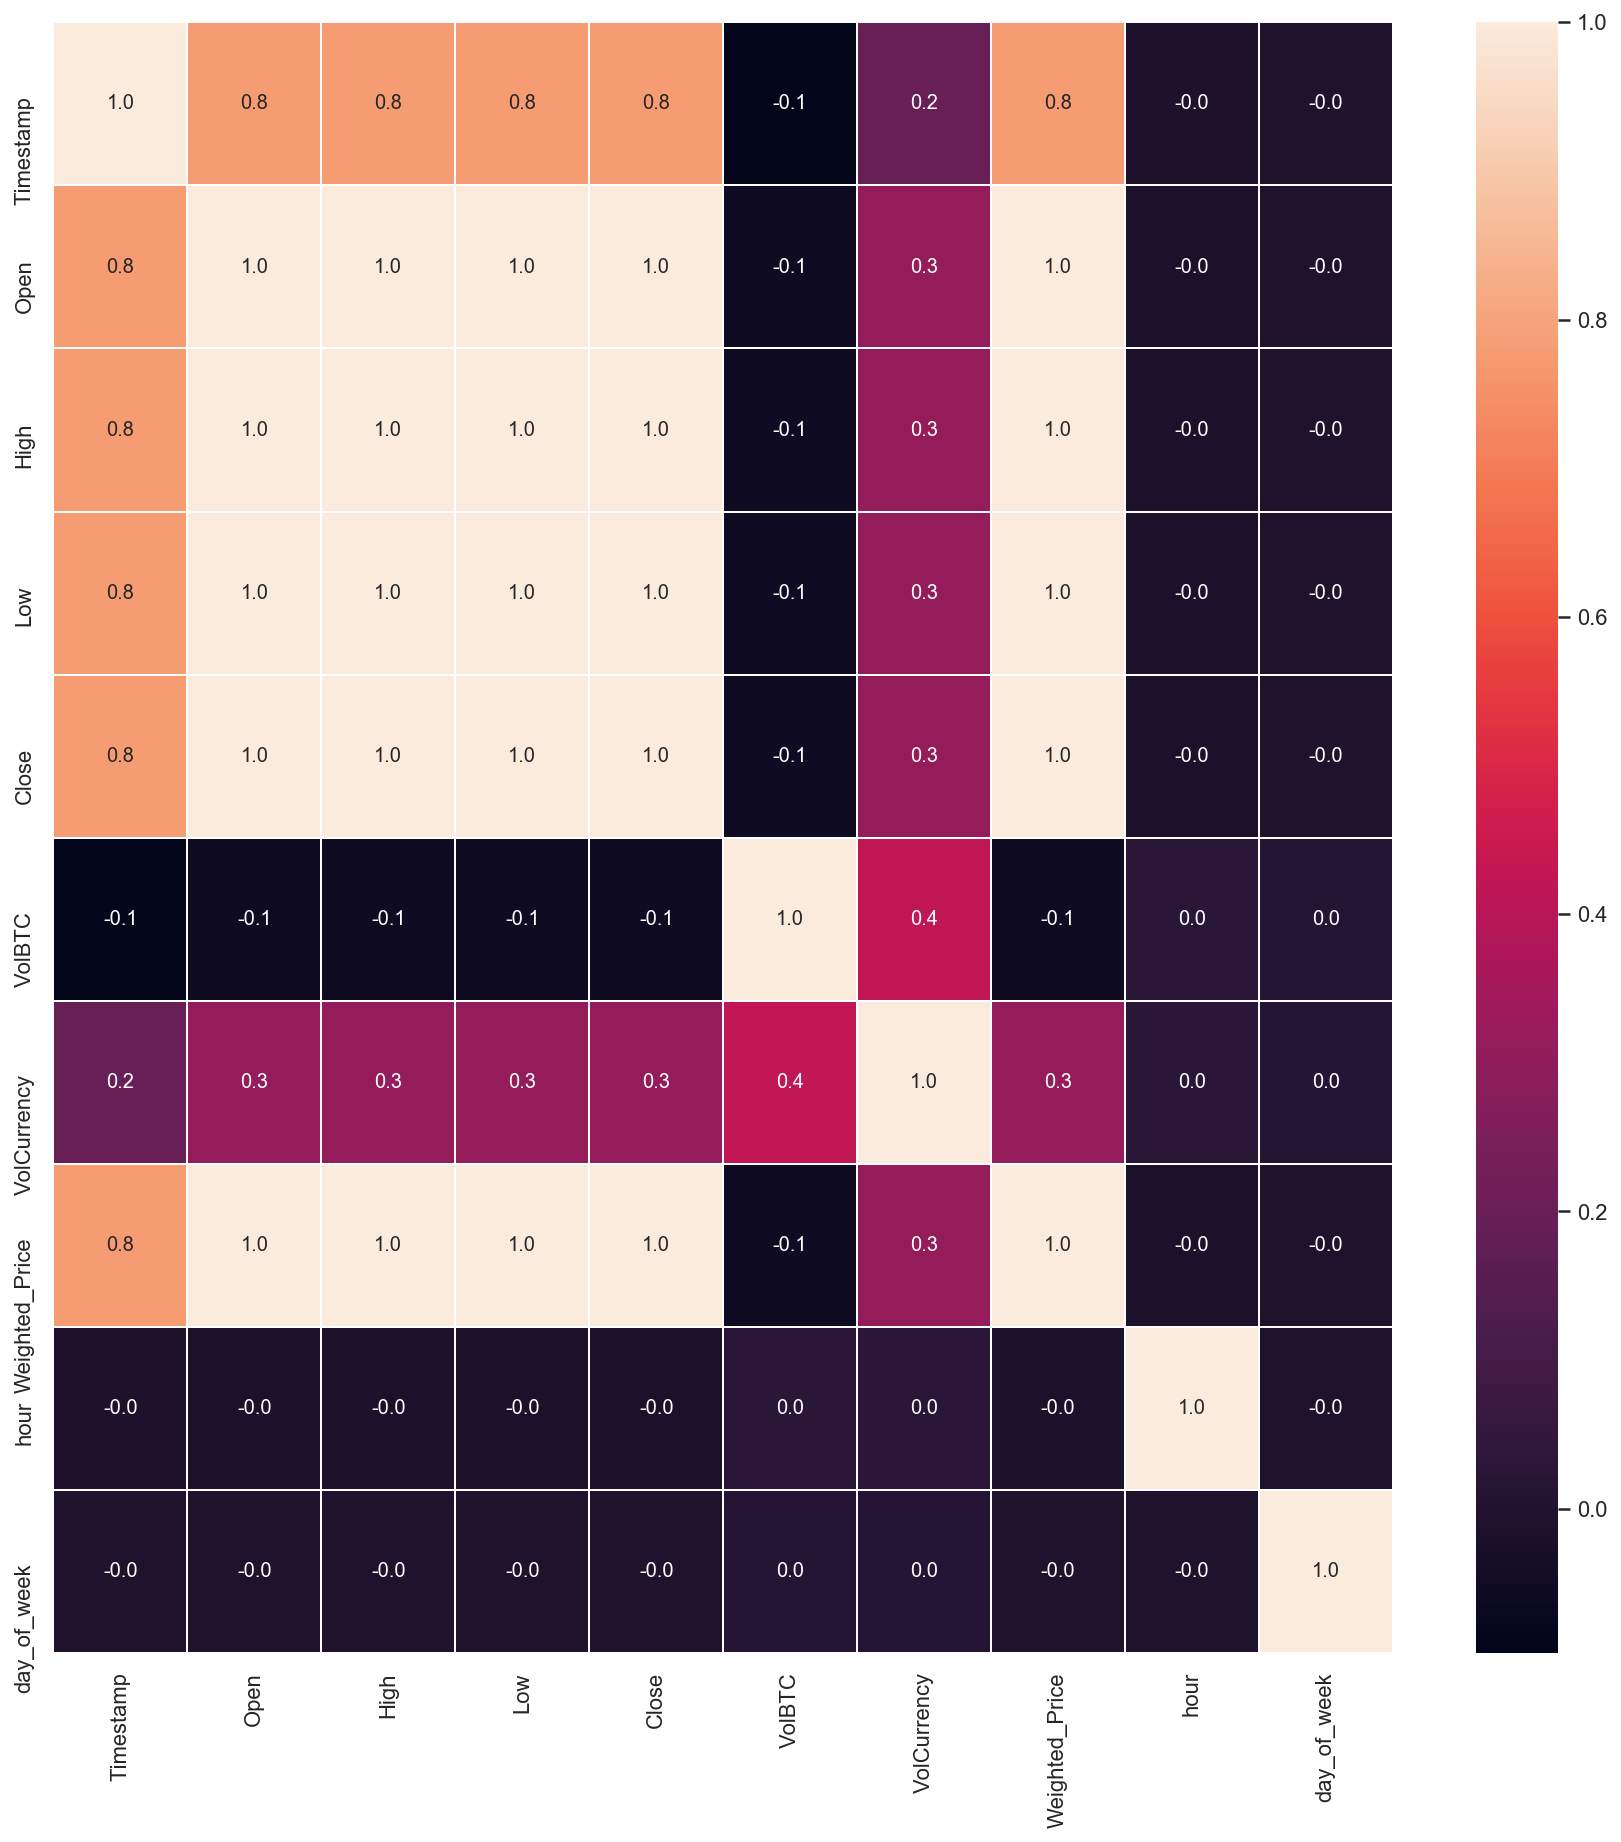

In [20]:
# Visualize Correaltions 
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlationMatrix,annot=True,linewidths=.5, fmt= '.1f',ax=ax)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB1F52BA58>,
      dtype=object)

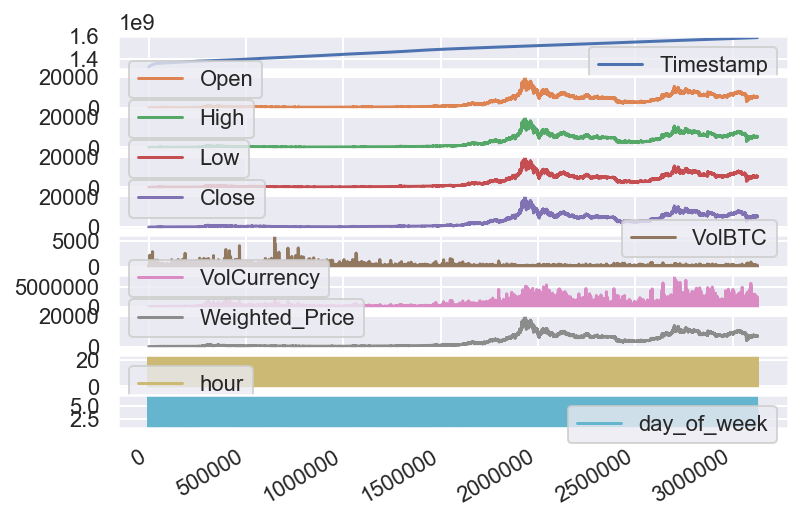

In [21]:
pandasDF.plot(subplots = True,figsize=(15, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB0ADAD978>,
      dtype=object)

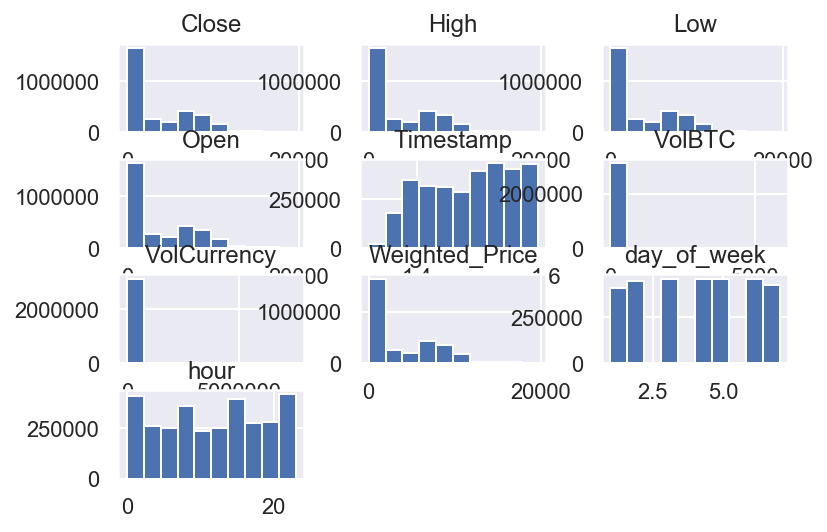

In [22]:
pandasDF.hist()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 0, 'BITCOIN Volume')

Text(0, 0.5, 'Currency Volume')

Text(0.5, 1.0, 'BITCOIN AND Currency Scatter Plot')

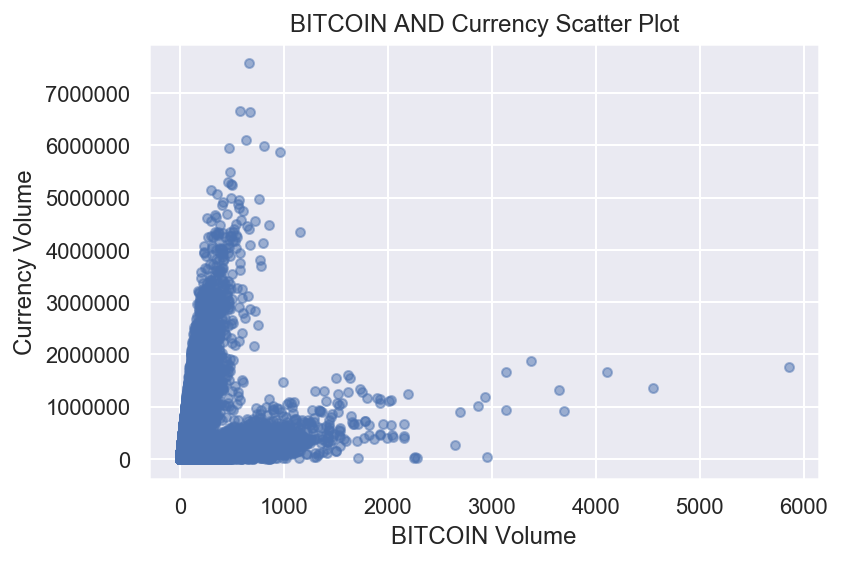

In [23]:
# Scatter Plot
pandasDF.plot(kind='scatter', x='VolBTC', y='VolCurrency',alpha = 0.5)
plt.xlabel('BITCOIN Volume')            
plt.ylabel('Currency Volume')
plt.title('BITCOIN AND Currency Scatter Plot') 
plt.show()

<Figure size 1440x576 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'price at the start of the time window')

Text(0.5, 1.0, 'Distribution of High and Low Price')

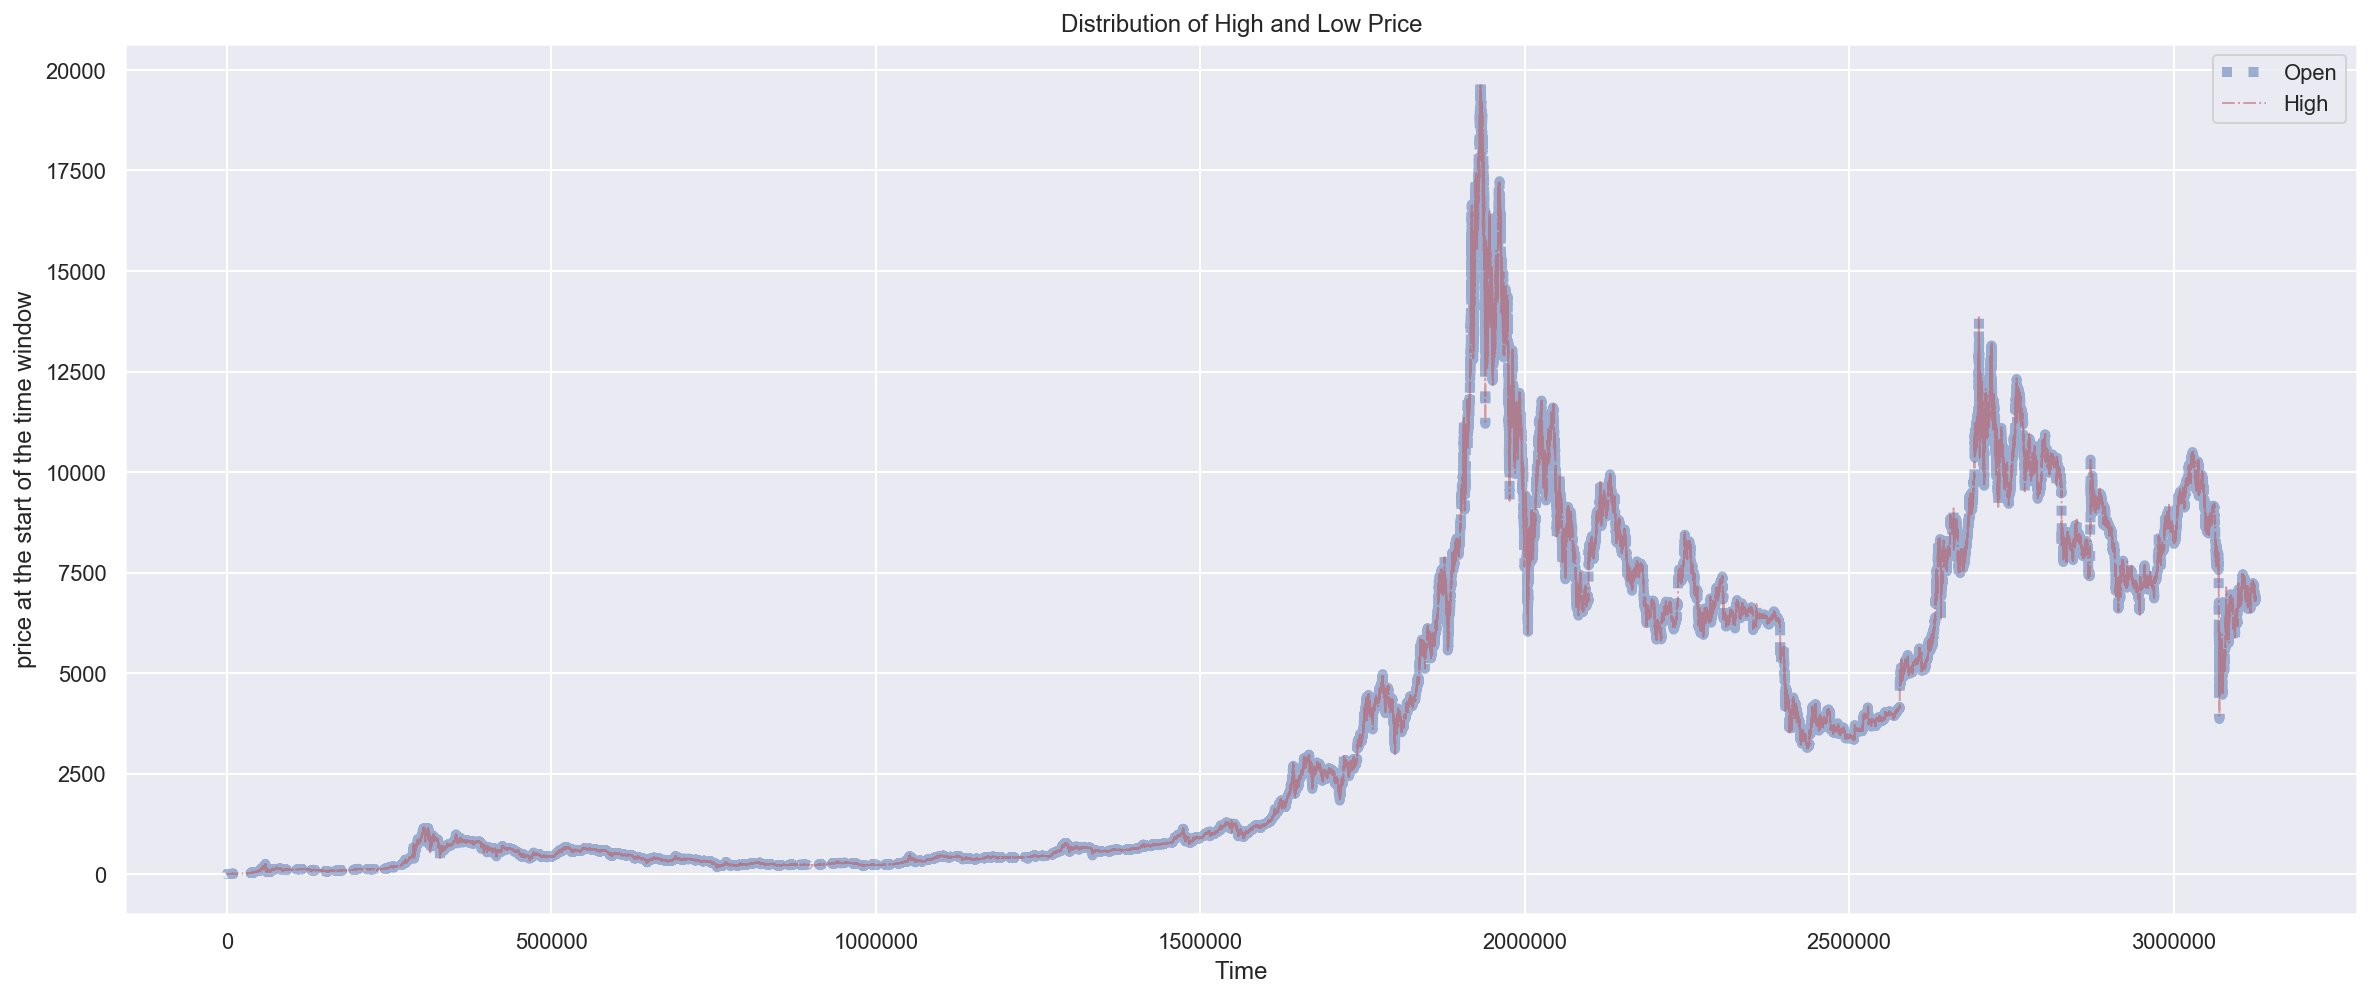

In [24]:
plt.figure(figsize=(20,8))
pandasDF.Open.plot(kind='line', color='b', label='Open', alpha=0.5, linewidth=5, grid=True, linestyle=':')
pandasDF.High.plot(color='r', label='High', linewidth=1, alpha=0.5, grid=True, linestyle='-.')
plt.legend(loc='upper right') 
plt.xlabel('Time')
plt.ylabel('price at the start of the time window')
plt.title('Distribution of High and Low Price')
plt.show()

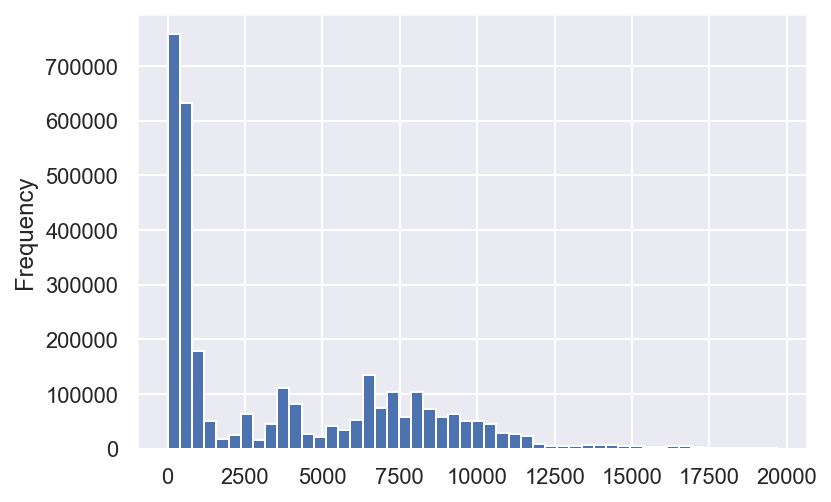

In [25]:
#plot of Open price
pandasDF.Open.plot(kind='hist', bins=50)

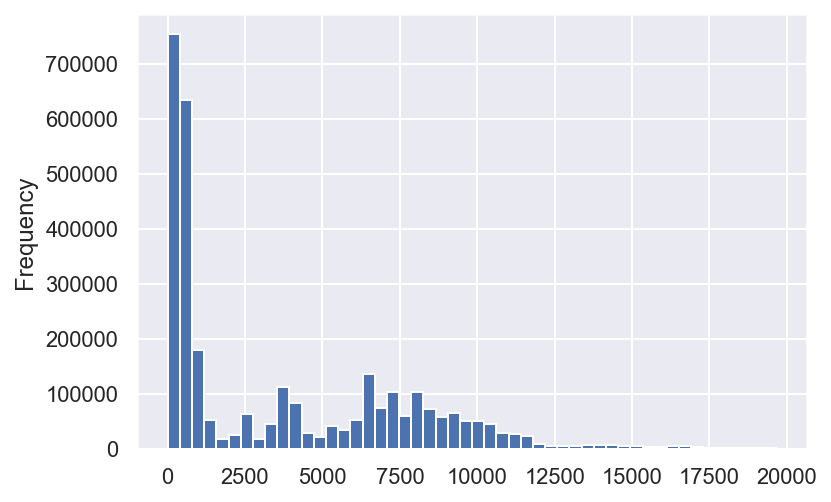

In [26]:
#plot of Close price
pandasDF.Close.plot(kind='hist', bins=50)

In [27]:
#Extract values for lists
hour=pandasDF["hour"].values.tolist()
weighted_price=pandasDF["Weighted_Price"].values.tolist()
volume_BTC=pandasDF["VolBTC"].values.tolist()
date_of_week=pandasDF["day_of_week"].values.tolist()
year=pandasDF["year"].values.tolist()

Text(0.5, 0, 'hour')

Text(0, 0.5, 'Weighted_Price')

Text(0.5, 1.0, 'Price by Hour')

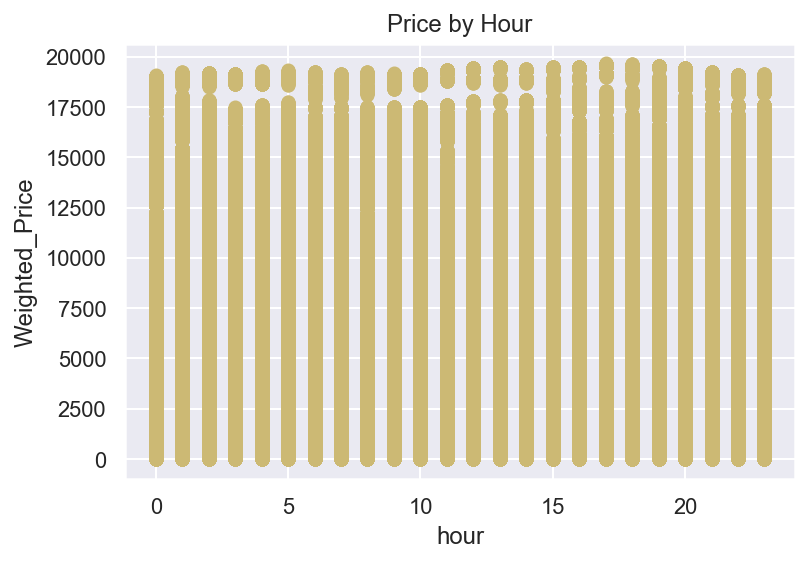

In [28]:
#Plot of Weighted_price per hour 
plt.plot(hour,weighted_price , 'yo')
plt.xlabel('hour')            
plt.ylabel('Weighted_Price')
plt.title('Price by Hour') 
plt.show()

Text(0.5, 0, 'day_of_week')

Text(0, 0.5, 'Weighted_Price')

Text(0.5, 1.0, 'Price By Week')

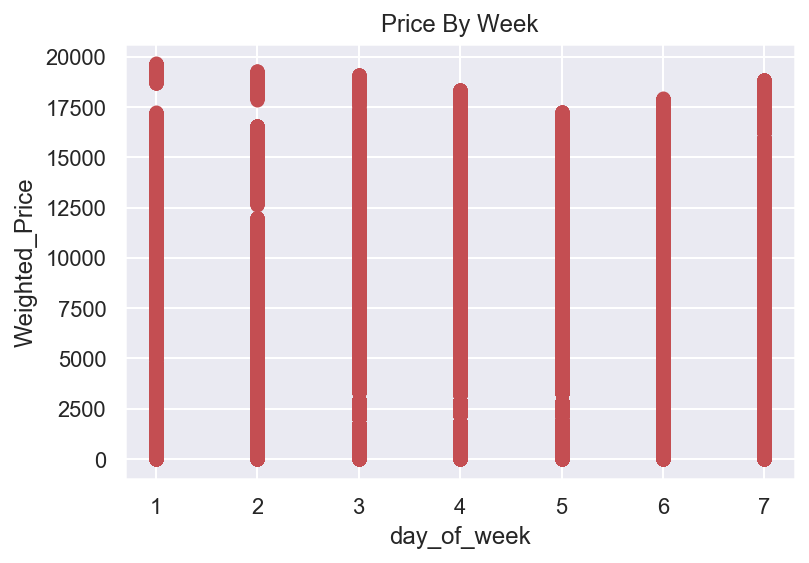

In [29]:
# Weighted_price per week 
plt.plot(date_of_week, weighted_price, 'ro')
plt.xlabel('day_of_week')            
plt.ylabel('Weighted_Price')
plt.title('Price By Week') 
plt.show()

Text(0.5, 0, 'hour')

Text(0, 0.5, 'VolBTC')

Text(0.5, 1.0, 'Volume by Hour of day')

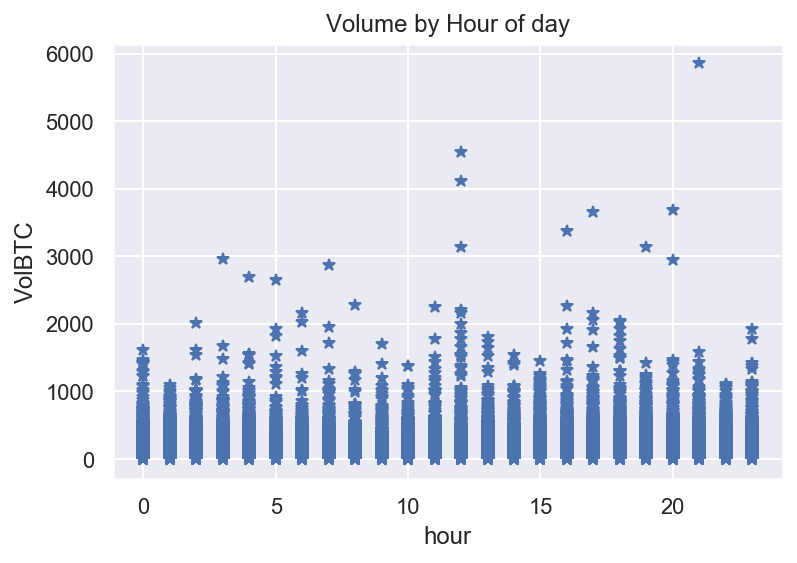

In [30]:
# VolBTC per hour change 
plt.plot(hour, volume_BTC, 'b*')
plt.xlabel('hour')            
plt.ylabel('VolBTC')
plt.title('Volume by Hour of day') 
plt.show()

Text(0.5, 0, 'day_of_week')

Text(0, 0.5, 'VolBTC')

Text(0.5, 1.0, 'Volume By Week')

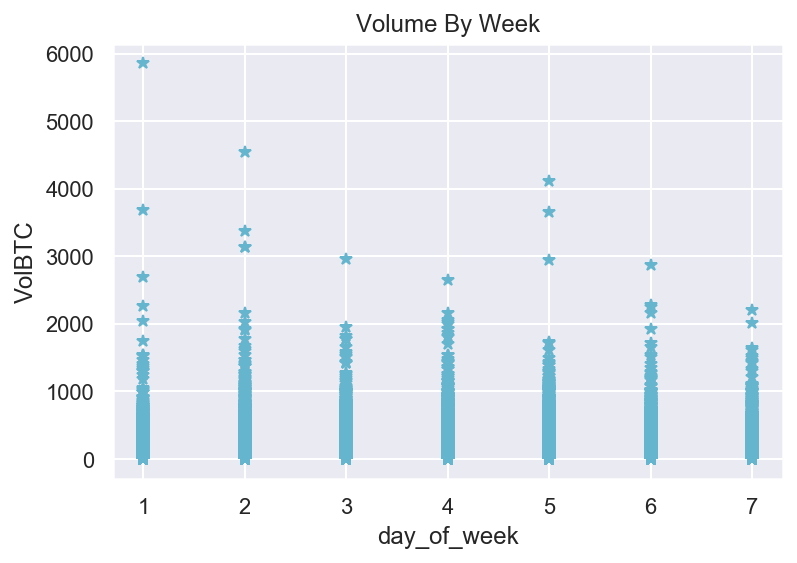

In [31]:
# VolBTC per day_of_Week 
plt.plot(date_of_week,volume_BTC , 'c*')
plt.xlabel('day_of_week')            
plt.ylabel('VolBTC')
plt.title('Volume By Week') 
plt.show()

Text(0.5, 0, 'year')

Text(0, 0.5, 'volume_BTC')

Text(0.5, 1.0, 'volume_BTC plotted in yearly basis')

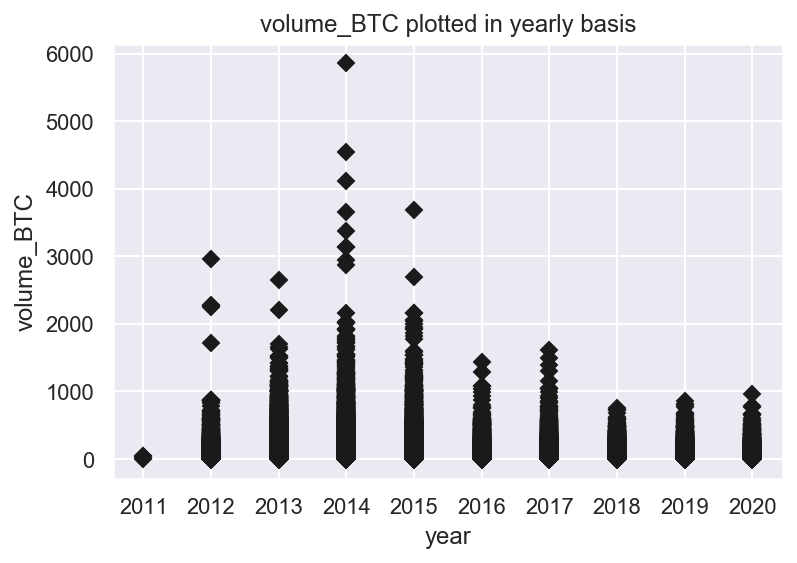

In [32]:
#Volume_BTC per year change 
plt.plot(year,volume_BTC , 'kD')
plt.xlabel('year')            
plt.ylabel('volume_BTC')
plt.title('volume_BTC plotted in yearly basis') 
plt.show()

Text(0.5, 0, 'year')

Text(0, 0.5, 'Weighted_Price')

Text(0.5, 1.0, 'Weighted Price in yearly basis')

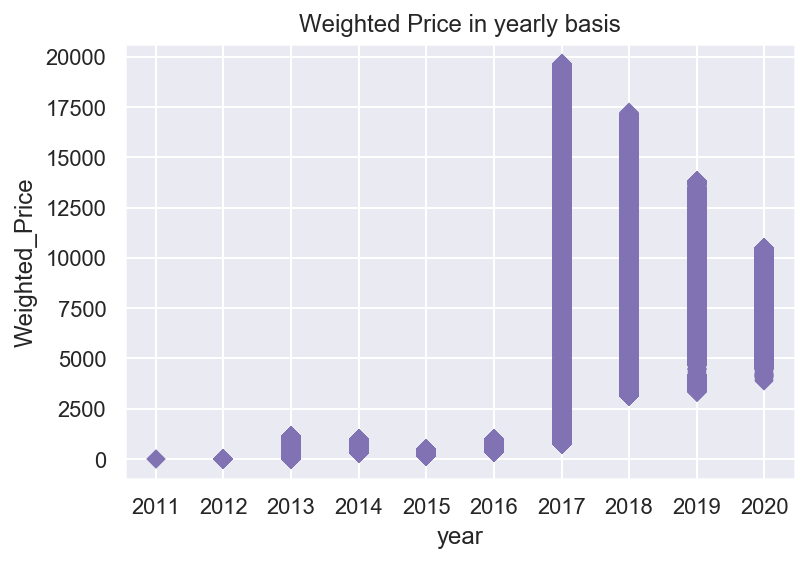

In [33]:
#Weighted Price per year change 
plt.plot(year,weighted_price , 'mD')
plt.xlabel('year')            
plt.ylabel('Weighted_Price')
plt.title('Weighted Price in yearly basis') 
plt.show()

In [34]:
# Create the Model

# Step1 - Extract Features  - Remove Highly Correalted features to the weighted_price
assembler = VectorAssembler(inputCols=['Timestamp','VolBTC','VolCurrency','Weighted_Price'], outputCol="features")
assembleDF = assembler.transform(bitCoinData)
assembleDF.show(10)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+--------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|            features|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+--------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 13:22:00|[1.32531792E9,0.4...|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 21:20:00|[1.3253466E9,48.0...|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 22:29:00|[1.32535074E9,37....|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 22:30:00|[1.3253508E9,9.0,...|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 09:46:00|[1.32539136E9,1.5...|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01

In [35]:
#Step2 - Normalize data using Min Max Scaler

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaleDF= scaler.fit(assembleDF).transform(assembleDF)
scaleDF.show(10)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+--------------------+--------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|            features|      scaledFeatures|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+--------------------+--------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 13:22:00|[1.32531792E9,0.4...|[0.0,7.7825824275...|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 21:20:00|[1.3253466E9,48.0...|[1.09383953236758...|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 22:29:00|[1.32535074E9,37....|[1.25173687072189...|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 22:30:00|[1.3253508E9,9.0,...|[1.25402523794442...|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|   

In [36]:
#Step3 - Split Testing and Training data
train_data,test_data = scaleDF.randomSplit([0.7,0.3], seed=12345)

In [37]:
# Step 4 - Build the Model (Linear Regression Model)
lineaRegression = LinearRegression(featuresCol='scaledFeatures',labelCol="Weighted_Price",predictionCol='Predicted_price',maxIter=100, regParam=0.3, elasticNetParam=0.8,standardization=False)

In [38]:
# Fit the data to the model
linearModel = lineaRegression.fit(train_data)

In [39]:
# GEt Predictions
predictions= linearModel.transform(test_data)

In [40]:
predict_data= predictions.select("Predicted_price", "Weighted_Price").show(10)

+------------------+--------------+
|   Predicted_price|Weighted_Price|
+------------------+--------------+
|2.3596129806449078|          4.58|
| 2.621052273840345|          4.84|
| 2.785362951797953|           5.0|
|3.1074339622429026|          5.32|
| 3.078371110288794|          5.29|
|  2.72053423198027|          4.93|
|2.7206604530090024|          4.93|
|2.9819998212233605|          5.19|
|3.1523019408249997|  5.3604618117|
| 4.253506831237978|          6.46|
+------------------+--------------+
only showing top 10 rows



In [41]:
evaluator = RegressionEvaluator(
    labelCol="Weighted_Price", predictionCol="Predicted_price", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error on test data = %g" % rmse)

Root Mean Squared Error on test data = 3.25276


In [42]:
pred_results=linearModel.evaluate(test_data)
Y = pred_results.predictions.select('Weighted_Price').toPandas()
_Y = pred_results.predictions.select("Predicted_price").toPandas()

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'BitCoin Weighted Prediction')

Text(0.5, 0, 'Weighted_Price')

Text(0, 0.5, 'Predicted_price')

C:\Users\User\Anaconda3\envs\yasas_env\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


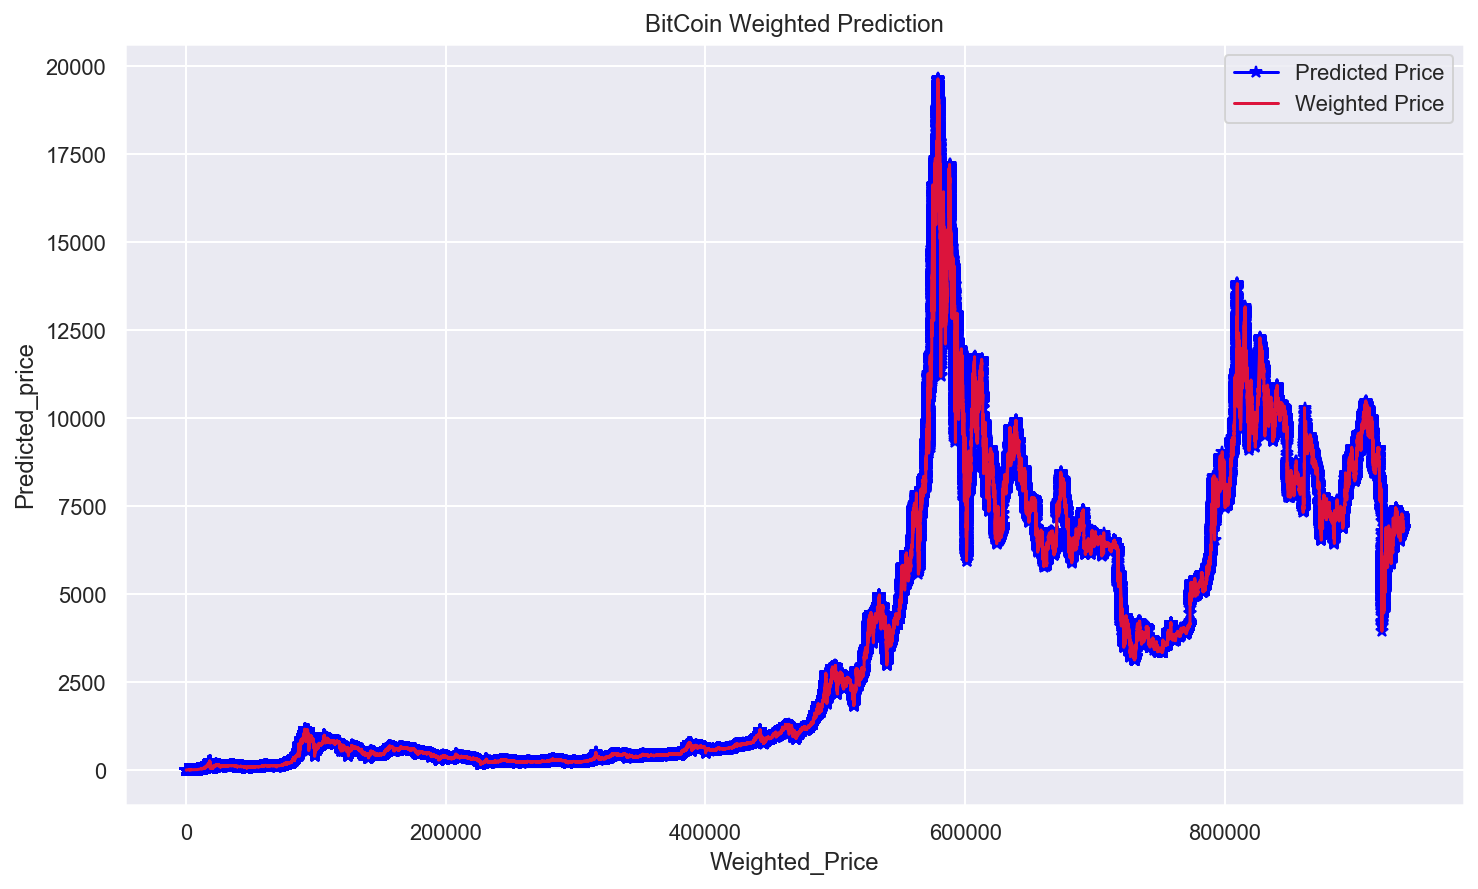

In [43]:
# Weighted_price vs Predicted_price using Matplotlib
plt.figure(figsize=(12,7))
plt.plot(Y, color='blue', marker='*', 
         label='Predicted Price')
plt.plot(_Y, color='crimson', label='Weighted Price')
plt.title('BitCoin Weighted Prediction')
plt.xlabel('Weighted_Price')
plt.ylabel('Predicted_price')
plt.legend()